MovieLens Analysis: Exploring How Genres' Average Ratings Have Evolved Over Time

Why does this matter?
- I love movies and this dataset piqued my curiosity. In aggregating this data, I can extrapolate interesting and valuable insight into how different genres have grown or shrunk across the decades.
- Through a business lens, these insights can be used by businesses that are involved with streaming services to recommend different movies and genres.

Dataset: Small dataset providing movie ratings, movie metadata (genres and year). Contains 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. The data was last updated 9/2018. Sourced from grouplens.org

Import and Setup

In [12]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path().cwd()

data_dir = PROJECT_ROOT / "Datasets" / "ml-latest-small"

links_df = pd.read_csv(data_dir / "links.csv")
movies_df =pd.read_csv(data_dir / "movies.csv")
ratings_df = pd.read_csv(data_dir / "ratings.csv")
tags_df = pd.read_csv(data_dir / "tags.csv")


Sanity Check

Before diving into any anlysis, let us verify that our data loaded properly and looks reasonable.

1. Row & Column Counts
    - Confirms with df.shape
2. Peek at the Data
    - Display a head of the records using df.head() to spot odd values or misaligned columns
3. Data Types and Nulls
    - Use df.info to validate column datatypes
4. Summary Statistics
    - Use df.describe() to ensure ranges make sense (e.g. ratings)

In [13]:
for name, df in [("movies", movies_df),
                 ("ratings", ratings_df),
                 ("links", links_df),
                 ("tags", tags_df)]:
    print(name, df.shape)
    display(df.head())
    df.info()
    df.describe()

movies (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
ratings (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
links (9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
tags (3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [14]:
# merge ratings with movie titles

merged = ratings_df.merge(
    movies_df[['movieId', 'title', 'genres']],
    on = 'movieId',
    how = 'left'
)

Here we have two tables, both offering different insights.
The first shows the top movies by count of ratings.
The seconf shows the top movies by highest mean rating (if more than 100 cumulative ratings).

In [15]:
# aggregate count and mean rating per movie
agg = (merged.groupby(['movieId', 'title'], as_index = False).rating.agg(
    count = 'size', mean = 'mean')
    )

#round mean to 2 decimal places
agg['mean'] = agg['mean'].round(2)

#extract year from title into agg
years_agg = agg['title'].str.extract(r'\((\d{4})\)$', expand = False)
agg['year'] = years_agg.astype('Int64')
agg['decade'] = (agg['year'] //10) * 10

# sorting by most rated
top_by_count = agg.sort_values('count', ascending = False).head(10)

# sorting by highest average rating when at least 100 ratings
best = agg[agg['count'] >= 100].sort_values('mean', ascending = False).head(10)

display(top_by_count)
display(best)

,movieId,title,count,mean,year,decade
314,356,Forrest Gump (1994),329,4.16,1994,1990
277,318,"Shawshank Redemption, The (1994)",317,4.43,1994,1990
257,296,Pulp Fiction (1994),307,4.20,1994,1990
510,593,"Silence of the Lambs, The (1991)",279,4.16,1991,1990
1938,2571,"Matrix, The (1999)",278,4.19,1999,1990
224,260,Star Wars: Episode IV - A New Hope (1977),251,4.23,1977,1970
418,480,Jurassic Park (1993),238,3.75,1993,1990
97,110,Braveheart (1995),237,4.03,1995,1990
507,589,Terminator 2: Judgment Day (1991),224,3.97,1991,1990
461,527,Schindler's List (1993),220,4.22,1993,1990


,movieId,title,count,mean,year,decade
277,318,"Shawshank Redemption, The (1994)",317,4.43,1994,1990
659,858,"Godfather, The (1972)",192,4.29,1972,1970
2224,2959,Fight Club (1999),218,4.27,1999,1990
921,1221,"Godfather: Part II, The (1974)",129,4.26,1974,1970
913,1213,Goodfellas (1990),126,4.25,1990,1990
6298,48516,"Departed, The (2006)",107,4.25,2006,2000
6693,58559,"Dark Knight, The (2008)",149,4.24,2008,2000
694,912,Casablanca (1942),100,4.24,1942,1940
46,50,"Usual Suspects, The (1995)",204,4.24,1995,1990
898,1197,"Princess Bride, The (1987)",142,4.23,1987,1980


In this chart, we will plot the mean movie rating for each decade so we can identify any trends in audience tastes over time.

,decade,avg_rating
0,1900,3.33
1,1910,3.25
2,1920,3.64
3,1930,3.59
4,1940,3.64
5,1950,3.58
6,1960,3.53
7,1970,3.50
8,1980,3.17
9,1990,3.16


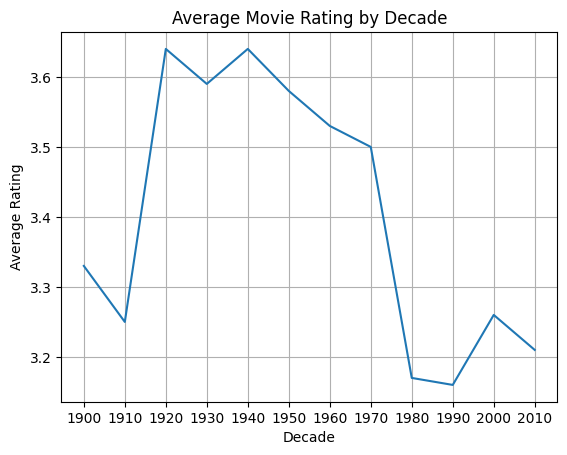

In [16]:
# aggregate to see how avg ratings vary by decade
agg['decade'] = (agg.year // 10) * 10
dec_agg = (agg.groupby('decade', as_index = False)['mean'].mean().round(2)
.rename(columns = {'mean':'avg_rating'})
)
display(dec_agg)

# plot line chart
plt.figure()
plt.plot(dec_agg['decade'], dec_agg['avg_rating'])
plt.xlabel('Decade')
plt.ylabel('Average Rating')
plt.title('Average Movie Rating by Decade')
plt.xticks(dec_agg['decade'])
plt.grid(True)
plt.show()

Based on the chart, average movie ratings hit their peak at 3.65 in 1920 and remained there for the next two decades. From 1940 to 1970, average ratings gradually tapered off from that 3.64 to 3.5. A sharp drop to 3.16 occured from 1970 to 1980 which could indicate a decrease in quality of films or, more likely, a general decrease in audience interest.

These trends could inform a streaming service's strategy for promoting classics over new releases.

Here we are creating two tables. One (top_highlt_rated) displays the top 5 highest rated genres with at least 10,000 ratings. The second (genre_stats) displays all genres with their mean rating and count of ratings.

Additionally, we will create a scatterplot to visualize the data from the top_highly_rated table.

In [17]:
# extracting year and decade
years = merged['title'].str.extract(r'\((\d{4})\)$', expand = False)
merged['year'] = years.astype('Int64')
merged['decade'] = (merged['year'] // 10) * 10

# split genres and explode
exploded = (merged.assign(genre = merged['genres'].str.split('|')
                         ).explode('genre'))

# average rating and total count per genre
genre_stats = (exploded.groupby('genre').rating.agg(count = 'size', mean = 'mean')
               .sort_values('count', ascending = False))

top_highly_rated = genre_stats[genre_stats['count'] >= 10000] \
.sort_values('mean', ascending = False).head(5)

display(top_highly_rated)
display(genre_stats)

,count,mean
genre,,
Crime,16681,3.658294
Drama,41928,3.656184
Adventure,24161,3.508609
Romance,18124,3.506511
Thriller,26452,3.493706


,count,mean
genre,,
Drama,41928,3.656184
Comedy,39053,3.384721
Action,30635,3.447984
Thriller,26452,3.493706
Adventure,24161,3.508609
Romance,18124,3.506511
Sci-Fi,17243,3.455721
Crime,16681,3.658294
Fantasy,11834,3.491001


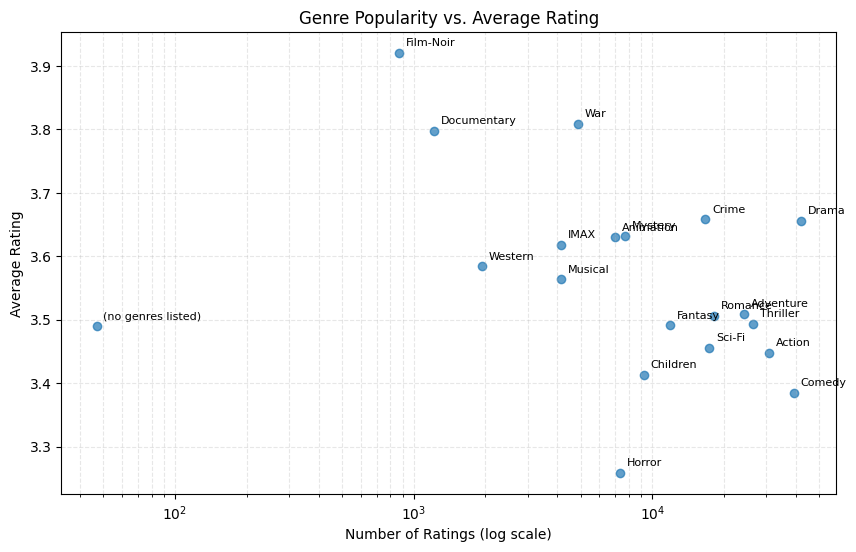

In [18]:
# scatterplot
plt.figure(figsize = (10,6))
plt.scatter(genre_stats['count'], genre_stats['mean'], alpha = 0.7)
plt.xscale('log')

plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Average Rating')
plt.title('Genre Popularity vs. Average Rating')

# annotations
top20 = genre_stats.nlargest(20, 'count')
for genre, row in top20.iterrows():
    plt.annotate(
        genre, (row['count'], row['mean']),
textcoords = 'offset points',
xytext = (5,5),
fontsize = 8
    )
plt.grid(True, which = 'both', ls = '--', alpha = 0.3)
plt.show()

Based off of the tables, we can see that drama is by far the most popular movie genre. Looking at the bottom of the table, we can locate the genre Film-Noir. This has the highest average rating of 3.92 but only 870 ratings in this dataset. We can say that this genre is very niche but has a passionate fanbase.

When observing the scatterplot, we can identify a few key takeaways:
- Horror has a vast number of ratings but boasts the lowest average rating score. People clearly go to see these movies but they often do not enjoy them.
- War and Documentary genre movies tend to have very high rating scores with a fairly high number of ratings.

In [19]:
# pivot table genre x decade
genre_decade_table = exploded.pivot_table(
    index = 'genre',          # rows represent each distinct genre
    columns = 'decade',       # cols represent each decade
    values = 'rating',        # what is being summarized
    aggfunc = 'mean'
).round(2)
display(genre_decade_table)

decade,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
genre,,,,,,,,,,,,
(no genres listed),NaN,NaN,NaN,NaN,NaN,3.00,3.00,4.00,4.50,3.67,NaN,3.28
Action,3.50,3.75,4.00,3.85,3.35,3.97,3.86,3.76,3.60,3.33,3.43,3.46
Adventure,3.50,3.75,3.95,3.78,3.57,3.85,3.75,3.74,3.62,3.36,3.51,3.53
Animation,4.00,NaN,2.33,3.61,3.50,3.44,3.65,3.49,3.65,3.64,3.65,3.63
Children,NaN,NaN,2.33,3.72,3.61,3.42,3.59,3.45,3.45,3.27,3.49,3.52
Comedy,4.00,3.33,3.79,3.82,3.90,3.75,3.69,3.73,3.42,3.33,3.32,3.43
Crime,2.50,NaN,3.75,3.55,4.01,4.02,3.88,4.02,3.49,3.68,3.60,3.56
Documentary,NaN,NaN,3.33,4.00,4.00,4.50,3.58,3.94,3.82,3.91,3.72,3.91
Drama,NaN,2.50,3.78,3.68,3.91,3.95,3.93,3.92,3.63,3.63,3.62,3.57
